In [175]:
### import packages ###
import time, sys, os
import h5py
import numpy as np
import scipy
import matplotlib.pyplot as plt
from matplotlib.pyplot import *

import fsps     # governs the fundamental stellar population synthesis models
import sedpy    # contains some routines for computing projecting spectra onto filter bandpasses

from sedpy import observate
from scipy.io import readsav

from PIL import Image
import requests

from astropy.io import fits
import astropy as ap
from astropy.cosmology import WMAP9
from astropy.visualization import make_lupton_rgb
from astropy.wcs import WCS as wcs

import astropy.coordinates as coord
from astroquery.sdss import SDSS
from astroquery import sha

sys.path.insert(0, '/mnt/c/Users/emma_d/ASTR_Research/lib/python3.8/site-packages/repo/prospector/')
import prospect     #likelihood evaluations, parameter priors, and posterior sampling

from prospect.utils.obsutils import fix_obs

import emcee
import dynesty

from prospect.models.sedmodel import SedModel
from prospect.models.templates import TemplateLibrary
from prospect.models import priors
from prospect.models import transforms

from prospect.likelihood import lnlike_spec, lnlike_phot, write_log
from prospect.likelihood import chi_spec, chi_phot

# from prospect.plotting.figuremaker import FigureMaker

from prospect.fitting import fit_model
from prospect.io import write_results as writer
from prospect import prospect_args  # - Parser with default arguments -

import prospect.plotting.figuremaker as fmkr

### re-defining plotting defaults ###
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'xtick.color': 'k'})
rcParams.update({'ytick.color': 'k'})
rcParams.update({'font.size': 30})

rcParams.update({'axes.facecolor':'w'})
rcParams.update({'savefig.facecolor':'w'})
rcParams.update({'lines.linewidth':'0.7'})

# print(rcParams.keys())

%matplotlib inline

# import warnings
# warnings.filterwarnings("ignore", category=RuntimeWarning)      #RunTimeWarnings are driving me nuts

### package versions ###
# vers = (np.__version__, scipy.__version__, h5py.__version__, fsps.__version__, prospect.__version__)
# print("numpy: {}\nscipy: {}\nh5py: {}\nfsps: {}\nprospect: {}".format(*vers))

In [176]:
start_time = time.time()

In [177]:
### My Unit Functions ###
def mJy_to_maggies(mJy):
    conversion_mJy_Jy = .001
    conversion_mJy_maggie = 3631
    return mJy * conversion_mJy_Jy/conversion_mJy_maggie

def f_nu_to_f_lambda_maggie(lam, f_nu):
    f_lambda_ergs = (10**-17 * f_nu) * (lam**2)/lightspeed
    f_lambda_mJy = (f_lambda_ergs / (1E-23)) * 1000
    f_lambda_maggie = mJy_to_maggies(f_lambda_mJy)
    return f_lambda_maggie

### Leja Functions for model_params ###
def transform_logmass_to_mass(mass=None, logmass=None, **extras):
    return 10**logmass

def load_gp(**extras):
    return None, None

def tie_gas_logz(logzsol=None, **extras):
    return logzsol

def to_dust1(dust1_fraction=None, dust1=None, dust2=None, **extras):
    return dust1_fraction*dust2

def transform_zfraction_to_sfrfraction(sfr_fraction=None, z_fraction=None, **extras):
    if sfr_fraction.size != 0:
        sfr_fraction[0] = 1-z_fraction[0]
        for i in list(range(1,sfr_fraction.shape[0])): 
            sfr_fraction[i] = np.prod(z_fraction[:i])*(1-z_fraction[i])
    return sfr_fraction

### Constants ###
lsun = 3.846e33
pc = 3.085677581467192e18 # in cm
lightspeed = 2.998e18 # AA/s
to_cgs = lsun/(4.0 * np.pi * (pc*10)**2)
jansky_mks = 1e-26


In [178]:
from prospect.sources import FastStepBasis

class FracSFH(FastStepBasis):
    
    @property
    def emline_wavelengths(self):
        return self.ssp.emline_wavelengths

    @property
    def get_nebline_luminosity(self):
        """Emission line luminosities in units of Lsun per solar mass formed"""
        return self.ssp.emline_luminosity/self.params['mass'].sum()

    def nebline_photometry(self,filters,z):
        """analytically calculate emission line contribution to photometry"""
        emlams = self.emline_wavelengths * (1+z)
        elums = self.get_nebline_luminosity # Lsun / solar mass formed
        flux = np.empty(len(filters))
        for i,filt in enumerate(filters):
            # calculate transmission at nebular emission
            trans = np.interp(emlams, filt.wavelength, filt.transmission, left=0., right=0.)
            idx = (trans > 0)
            if True in idx:
                flux[i] = (trans[idx]*emlams[idx]*elums[idx]).sum()/filt.ab_zero_counts
            else:
                flux[i] = 0.0
        return flux

    def get_galaxy_spectrum(self, **params):
        self.update(**params)

        #### here's the custom fractional stuff
        fractions = np.array(self.params['sfr_fraction'])
        bin_fractions = np.append(fractions,(1-np.sum(fractions)))
        time_per_bin = []
        for (t1, t2) in self.params['agebins']: time_per_bin.append(10**t2-10**t1)
        bin_fractions *= np.array(time_per_bin)
        bin_fractions /= bin_fractions.sum()
        
        mass = bin_fractions*self.params['mass']
        mtot = self.params['mass'].sum()

        time, sfr, tmax = self.convert_sfh(self.params['agebins'], mass)
        self.ssp.params["sfh"] = 3 #Hack to avoid rewriting the superclass
        self.ssp.set_tabular_sfh(time, sfr)
        wave, spec = self.ssp.get_spectrum(tage=tmax, peraa=False)

        return wave, spec / mtot, self.ssp.stellar_mass / mtot

    def get_spectrum(self, outwave=None, filters=None, peraa=False, **params):
        """Get a spectrum and SED for the given params.
        ripped from SSPBasis
        addition: check for flag nebeminspec. if not true,
        add emission lines directly to photometry"""

        # Spectrum in Lsun/Hz per solar mass formed, restframe
        wave, spectrum, mfrac = self.get_galaxy_spectrum(**params)

        # Redshifting + Wavelength solution
        # We do it ourselves.
        a = 1 + self.params.get('zred', 0)
        af = a
        b = 0.0

        if 'wavecal_coeffs' in self.params:
            x = wave - wave.min()
            x = 2.0 * (x / x.max()) - 1.0
            c = np.insert(self.params['wavecal_coeffs'], 0, 0)
            # assume coeeficients give shifts in km/s
            b = chebval(x, c) / (lightspeed*1e-13)

        wa, sa = wave * (a + b), spectrum * af  # Observed Frame
        if outwave is None:
            outwave = wa
        
        spec_aa = lightspeed/wa**2 * sa # convert to perAA
        # Observed frame photometry, as absolute maggies
        if filters is not None:
            mags = observate.getSED(wa, spec_aa * to_cgs, filters)
            phot = np.atleast_1d(10**(-0.4 * mags))
        else:
            phot = 0.0

        ### if we don't have emission lines, add them
        if (not self.params['nebemlineinspec']) and self.params['add_neb_emission']:
            phot += self.nebline_photometry(filters,a-1)*to_cgs

        # Spectral smoothing.
        do_smooth = (('sigma_smooth' in self.params) and
                     ('sigma_smooth' in self.reserved_params))
        if do_smooth:
            # We do it ourselves.
            smspec = self.smoothspec(wa, sa, self.params['sigma_smooth'],
                                     outwave=outwave, **self.params)
        elif outwave is not wa:
            # Just interpolate
            smspec = np.interp(outwave, wa, sa, left=0, right=0)
        else:
            # no interpolation necessary
            smspec = sa

        # Distance dimming and unit conversion
        zred = self.params.get('zred', 0.0)
        if (zred == 0) or ('lumdist' in self.params):
            # Use 10pc for the luminosity distance (or a number
            # provided in the dist key in units of Mpc)
            dfactor = (self.params.get('lumdist', 1e-5) * 1e5)**2
        else:
            lumdist = WMAP9.luminosity_distance(zred).value
            dfactor = (lumdist * 1e5)**2
        if peraa:
            # spectrum will be in erg/s/cm^2/AA
            smspec *= to_cgs / dfactor * lightspeed / outwave**2
        else:
            # Spectrum will be in maggies
            smspec *= to_cgs / dfactor / 1e3 / (3631*jansky_mks)

        # Convert from absolute maggies to apparent maggies
        phot /= dfactor

        # Mass normalization
        mass = np.sum(self.params.get('mass', 1.0))
        if np.all(self.params.get('mass_units', 'mstar') == 'mstar'):
            # Convert from current stellar mass to mass formed
            mass /= mfrac

        return smspec * mass, phot * mass, mfrac

In [179]:
### Import full galaxy file (58 galaxies) ###
AGN_file = fits.open('/mnt/c/Users/emma_d/ASTR_Research/Data/asu.fit')
AGN_data = AGN_file[1].data

In [180]:
### Flux data ###
FFUV = mJy_to_maggies(AGN_data.field(4))
FNUV = mJy_to_maggies(AGN_data.field(6))
Fu = mJy_to_maggies(AGN_data.field(8))
Fg = mJy_to_maggies(AGN_data.field(10))
Fr = mJy_to_maggies(AGN_data.field(12))
Fi = mJy_to_maggies(AGN_data.field(14))
Fz = mJy_to_maggies(AGN_data.field(16))
FJ = mJy_to_maggies(AGN_data.field(18))
FH = mJy_to_maggies(AGN_data.field(20))
FKs = mJy_to_maggies(AGN_data.field(22))
F3_4 = mJy_to_maggies(AGN_data.field(24))
F4_6 = mJy_to_maggies(AGN_data.field(26))
F12 = mJy_to_maggies(AGN_data.field(28))
F22 = mJy_to_maggies(AGN_data.field(31))
F70 = mJy_to_maggies(AGN_data.field(33))
F100 = mJy_to_maggies(AGN_data.field(35))
F160 = mJy_to_maggies(AGN_data.field(37))
F250 = mJy_to_maggies(AGN_data.field(39))
F350 = mJy_to_maggies(AGN_data.field(42))
F500 = mJy_to_maggies(AGN_data.field(45))

Flux_Data = np.column_stack((FFUV, FNUV, Fu, Fg, Fr, Fi, Fz, F3_4, F4_6, F12, F22, F70, F100, F160, F250, F350, F500, FJ, FH, FKs))

### Filter uncertainty in mJy ###
FFUVe = mJy_to_maggies(AGN_data.field(5))
FNUVe = mJy_to_maggies(AGN_data.field(7))
Fue = mJy_to_maggies(AGN_data.field(9))
Fge = mJy_to_maggies(AGN_data.field(11))
Fre = mJy_to_maggies(AGN_data.field(13))
Fie = mJy_to_maggies(AGN_data.field(15))
Fze = mJy_to_maggies(AGN_data.field(17))
FJe = mJy_to_maggies(AGN_data.field(19))
FHe = mJy_to_maggies(AGN_data.field(21))
FKse = mJy_to_maggies(AGN_data.field(23))
F3_4e = mJy_to_maggies(AGN_data.field(25))
F4_6e = mJy_to_maggies(AGN_data.field(27))
F12e = mJy_to_maggies(AGN_data.field(29))
F22e = mJy_to_maggies(AGN_data.field(32))
F70e = mJy_to_maggies(AGN_data.field(34))
F100e = mJy_to_maggies(AGN_data.field(36))
F160e = mJy_to_maggies(AGN_data.field(38))
F250e = mJy_to_maggies(AGN_data.field(40))
F350e = mJy_to_maggies(AGN_data.field(43))
F500e = mJy_to_maggies(AGN_data.field(46))

In [181]:
### Choose a galaxy (0 to 57) ###
# Explorer Path = C:\Users\emma_d\ASTR_Research\Galaxy_output\G0

galaxy_num = 33
Template_Type = 'alpha_agn'

if not os.path.exists('Galaxy_output/G{}/'.format(galaxy_num)):
    os.mkdir('Galaxy_output/G{}/'.format(galaxy_num))
Galaxy_Path = 'Galaxy_output/G{}/'.format(galaxy_num)

print('This is for Galaxy ', galaxy_num + 1)

ts = time.strftime("%y%b%d", time.localtime())
print('The Date is', ts)
print('The template type is', Template_Type)
# print('The redshift is ', G_Redshift)

This is for Galaxy  34
The Date is 21Jun18
The template type is alpha_agn


In [182]:
# Query SDSS to get optical spectra data
#   Used tutorial from 
#       https://learn.astropy.org/rst-tutorials/User-Defined-Model.html 
#       http://astroweb.case.edu/jakub/TA/Interpolation.html 
Gal_RA, Gal_DEC = AGN_data[galaxy_num][2], AGN_data[galaxy_num][3]
pos = coord.SkyCoord(Gal_RA, Gal_DEC, unit='deg',frame='icrs')
xid = SDSS.query_region(pos, spectro=True)
xid

/home/emma/.local/lib/python3.8/site-packages/astroquery/sdss/core.py:862: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


<Table length=1>
       ra             dec               objid        ... run2d instrument
    float64         float64             int64        ... int64   bytes4  
--------------- ---------------- ------------------- ... ----- ----------
169.78179862573 58.0539723805796 1237658302207426603 ...    26       SDSS

In [183]:
### Redshift ###
G_Redshift = xid['z'][0]                                        # Use redshift from SDSS query

cosmo = ap.cosmology.FlatLambdaCDM(H0=70, Om0=0.3)              # cosmological redshift object
ldist_Mpc_units = cosmo.comoving_distance(G_Redshift)           # cosmological redshift

ldist_Mpc = ldist_Mpc_units.value                               # Get ldist in Mpc from ldist with units
tage_of_univ = WMAP9.age(G_Redshift).value                      # age of the universe in Gyr

# im = SDSS.get_images(matches=xid, band='gri') #, band='g'

In [184]:
### Put in optical image from SDSS ###

# http://skyserver.sdss.org/dr16/SkyServerWS/ImgCutout/getjpeg?TaskName=Skyserver.Chart.List&ra=159.815&dec=-0.655&scale=0.4&width=120&height=120&opt=


# plt.imshow(im[0].data)
# plt.imshow(im[1].data)
# plt.imshow(im[2].data)


# imshow(im[0][0].data)

In [185]:
### Get optical spectrum from SDSS query ###
optical_spectrum = SDSS.get_spectra(plate= xid['plate'][0], fiberID= xid['fiberID'][0], mjd= xid['mjd'][0])[0] 

[O_II] 3727  -> [3729.875448]
[O_III] 5007  -> [5008.23963773]
H_alpha  -> [6564.61389433]


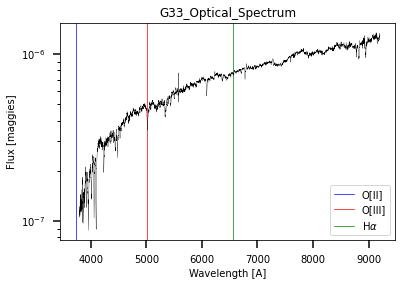

In [186]:
### Plot optical spectrum ###
optical_spectrum_flux = optical_spectrum[1].data['flux']
optical_spectrum_lam = 10 ** (optical_spectrum[1].data['loglam'])

# Spectra lines for OII, OIII, Halpha
optical_spectrum_lines = optical_spectrum[3].data
for n in ['[O_II] 3727', '[O_III] 5007', 'H_alpha']:
    print(n, " ->", optical_spectrum_lines['LINEWAVE'][optical_spectrum_lines['LINENAME']==n])
plt.axvline(x=optical_spectrum_lines['LINEWAVE'][optical_spectrum_lines['LINENAME']=='[O_II] 3727'], label=r'O[II]', color='blue')
plt.axvline(x=optical_spectrum_lines['LINEWAVE'][optical_spectrum_lines['LINENAME']=='[O_III] 5007'], label=r'O[III]', color='red')
plt.axvline(x=optical_spectrum_lines['LINEWAVE'][optical_spectrum_lines['LINENAME']=='H_alpha'], label=r'H$\alpha$', color='green')

# Find what units the data is in
units_flux = optical_spectrum[0].header['bunit']
units_wavelength_full = optical_spectrum[0].header['WAT1_001']
units_wavelength = units_wavelength_full[36:]

# Convert SDSS units to Prospector units
optical_spectrum_flux = f_nu_to_f_lambda_maggie(optical_spectrum_lam, optical_spectrum_flux)

# Plot the spectra
plot(optical_spectrum_lam, optical_spectrum_flux, color='k', linewidth=.3)
xlabel('Wavelength [A]')
ylabel('Flux [maggies]')
title('G{0}_Optical_Spectrum'.format(galaxy_num))
yscale('log')
legend()

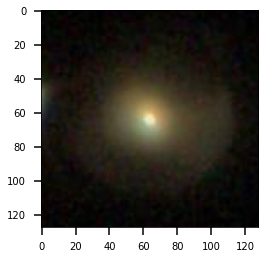

In [187]:
### Get optical image from the url using galaxy RA and DEC ###
SDSS_URL = 'http://skyserver.sdss.org/dr16/SkyServerWS/ImgCutout/getjpeg?TaskName=Skyserver.Chart.List&ra={0}&dec={1}'.format(Gal_RA, Gal_DEC)

SDSS_Image = Image.open(requests.get(SDSS_URL, stream=True).raw)
imshow(SDSS_Image)

In [188]:
# images = SDSS.get_images(matches=xid, band='gri')
# image_data_g =  images[0][0].data
# image_data_r =  images[1][0].data
# image_data_i =  images[2][0].data


# images[0][0].header.rename_keyword('RADECSYS', 'RADESYS')

# images[0].info()
# wcs_g = wcs(images[0][0].header)

# rgb_default = make_lupton_rgb(image_data_i, image_data_r, image_data_g)
# rgb = make_lupton_rgb(image_data_i, image_data_r, image_data_g, Q=10, stretch=0.25)
# plt.imshow(rgb, origin='lower')
# plt.subplot(projection=wcs_g)


In [189]:
# images[0][0].header

In [190]:
# clipped_image = image_data.copy()
# clipped_image[clipped_image>1.0]=1.0

# # plt.figure(figsize=(10,10))
# plt.imshow(clipped_image)
# plt.colorbar()

In [191]:
### From Dr. Smercina ###
ea_struct = readsav('Data/ea_struct_v9.sav')['ea_struct']
# ea_struct.dtype.names                                     # Keys in ea_struct

In [192]:
# gal_EA_Desig = AGN_data[galaxy_num][1][2:]
# s1, = np.where(ea_struct.source.astype(str) == 'Spitzer')        # Pulls only spitzer from herschel + spitzer sources
# ea_struct = ea_struct[s1]

# if gal_EA_Desig in ea_struct['EA_DESIG'].astype(str):
#     IRS_indicator = 1
#     print('There is Spitzer IRS spectrum data for this galaxy')
#     s, = np.where(ea_struct.ea_desig.astype(str) == gal_EA_Desig)
#     print('This is galaxy', gal_EA_Desig)


#     IRS_wavelength = ea_struct[s][0].irs_spectrum.wave
#     IRS_flux = ea_struct[s][0].irs_spectrum.flux
#     plt.plot(IRS_wavelength, IRS_flux)
#     plt.xlabel('Wavelength [mu m]')
#     plt.ylabel('Flux [maggie]')
#     plt.title('G{0}_IRS_Spectrum'.format(galaxy_num))
#     plt.yscale('log')

# else:
#     IRS_indicator = 0
#     print('There is no Spitzer IRS spectrum data for this galaxy')
#     print('This is galaxy', gal_EA_Desig)

There is Spitzer IRS spectrum data for this galaxy
This is galaxy S07 33


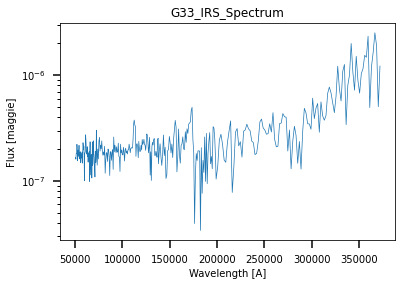

In [193]:
gal_EA_Desig = AGN_data[galaxy_num][1][2:]
s1, = np.where(ea_struct.source.astype(str) == 'Spitzer')       # Pulls only spitzer from sources
ea_struct = ea_struct[s1]                                       # Masks ea_struct to get spitzer galaxies

# If the IRS data contains the galaxy, graph the IRS data. If not print there is no IRS data.
if gal_EA_Desig in ea_struct['EA_DESIG'].astype(str):
    IRS_indicator = 1                                           # Indicates there is IRS data
    print('There is Spitzer IRS spectrum data for this galaxy')
    s, = np.where(ea_struct.ea_desig.astype(str) == gal_EA_Desig)

    # Convert Smercina units (mu*m,nu*f_nu) to prospector units (A, maggies)
    IRS_wavelength = ea_struct[s][0].irs_spectrum.wave * 10000
    IRS_flux = mJy_to_maggies(10**13 *(ea_struct[s][0].irs_spectrum.wave/(2.998*10**14)) * ea_struct[s][0].irs_spectrum.flux)

    # Masks where IRS_FLUX is very low (~= 0)
    IRS_wavelength =IRS_wavelength[ IRS_flux > 10**-9 ]
    IRS_flux = IRS_flux[ IRS_flux > 10**-9 ]

    # Plot IRS data
    plot(IRS_wavelength, IRS_flux)
    xlabel('Wavelength [A]')
    ylabel('Flux [maggie]')
    title('G{0}_IRS_Spectrum'.format(galaxy_num))
    yscale('log')

else:
    IRS_indicator = 0                                           # Indicates there is no IRS data
    print('There is no Spitzer IRS spectrum data for this galaxy')

print('This is galaxy', gal_EA_Desig, galaxy_num)

In [194]:
### Create run_params dictionary ###
run_params = { 'ldist': ldist_Mpc,
                'agelims': [0.0,8.0,8.5,9.0,9.5,9.8,10.0],
                'object_redshift': G_Redshift,
                'zcontinuous': 1,                           # Leja: 2
                'verbose': False,                           # Lega: True
                'dynesty': False,                           # Change in code
                'emcee': False,                             # Change in code
                'optimize': False,                          # Change in code
                'optimization': False,
                'min_method': 'lm',                     #'lm',
                'nmin': 5,                                  # initially 2, can try 1
                'nwalkers': 128,                            # Leja: 620
                'niter': 512,                               # Leja: 7500
                'nburn': [16, 32, 64],                      # Leja: [150, 200, 200]
                'optimization': False,
                'nested_method': 'rwalk',
                'nlive_init': 400,
                'nlive_batch': 200,
                'nested_dlogz_init': 0.05,
                'nested_posterior_thresh': 0.05,
                'nested_maxcall': int(1e7),

                # From Leja:
                'objname': 'G{0}_{1}'.format(galaxy_num, Template_Type),
                'initial_disp': 0.1

                # 'nofork': True,
                # 'ftol': 0.5e-5
                # 'maxfev': 5000,
                # 'interval': 0.2,
                # 'convergence_check_interval': 50,
                # 'convergence_chunks': 325,
                # 'convergence_kl_threshold': 0.016,
                # 'convergence_stable_points_criteria': 8, 
                # 'convergence_nhist': 50,
                # 'compute_vega_mags': False,
                # 'interp_type': 'logarithmic',
                }

In [195]:
### Build a dictionary of observational data to use in fit ###
def build_obs( **extras):
    obs = {}

    # Filters (same order as photometric data) ###
    galex = ['galex_FUV', 'galex_NUV']
    galex_unc = FFUVe, FNUVe

    sdss = ['sdss_{0}0'.format(b) for b in ['u','g','r','i','z']]
    sdss_unc = Fue, Fge, Fre, Fie, Fze

    allWise = ['wise_w{0}'.format(b) for b in ['1','2','3','4']]
    allWise_unc = F3_4e, F4_6e, F12e, F22e

    herschel_pacs = ['herschel_pacs_{0}'.format(b) for b in ['70','100','160']]
    herschel_pacs_unc = F70e, F100e, F160e

    herschel_spire = ['herschel_spire_{0}'.format(b) for b in ['250','350','500']]
    herschel_spire_unc = F250e, F350e, F500e

    twomass = ['twomass_{0}'.format(b) for b in ['H','J','Ks']]          #Turned off 2mass
    twomass_unc = FHe, FJe, FKse

    # Put all filters into an array
    filternames = galex + sdss + allWise + herschel_pacs + herschel_spire + twomass
    obs["filters"] = sedpy.observate.load_filters(filternames)

    # Flux data (in same order as filters) in maggies 
    obs["maggies"] = Flux_Data[galaxy_num]

    # Uncertainties (same order as filters) in maggies 
    uncertainty_cols = galex_unc, sdss_unc, allWise_unc, herschel_pacs_unc, herschel_spire_unc , twomass_unc

    maggies_uncertainy = np.vstack(uncertainty_cols).T      #transposed to get the row data not the column data
    obs["maggies_unc"] = maggies_uncertainy[galaxy_num]

    obs["phot_mask"] = np.full((len(Flux_Data[galaxy_num])), True, dtype=bool)  # use all photomectric data
    # obs["phot_mask"] = np.ones((len(Flux_Data[galaxy_num])), dtype=bool)
    # obs["phot_mask"] = obs['maggies'] != 0

    ### Array of effective wavelengths for each filter (not necessary, but can be useful for plotting) ###
    obs["phot_wave"] = np.array([f.wave_effective for f in obs["filters"]])

    obs["wavelength"] = None    # vector of vaccum λs in angstroms
    obs["spectrum"] = None      # in maggies
    obs['unc'] = None           # spectral uncertainties
    obs['mask'] = None

    obs = fix_obs(obs)      # Ensures all required keys are present in the obs dictionary

    return obs

In [196]:
### Built obs dict using meta-params ###
obs = build_obs(**run_params)

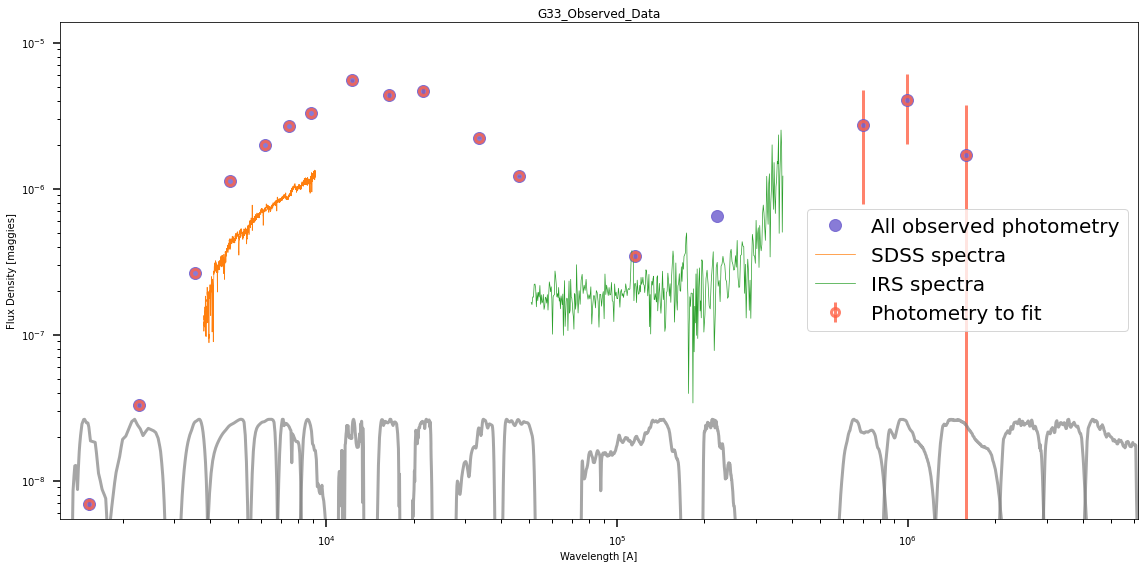

In [197]:
### Plot all observed data ###
wphot = obs["phot_wave"]
mask = obs["phot_mask"]

mask_len_array = len(obs['maggies'][obs["phot_mask"]])
xmin, xmax = np.min(wphot)*0.8, np.max(wphot)/0.8
ymin, ymax = obs["maggies"][mask].min()*0.8, obs["maggies"][mask].max()/0.4  
figure(figsize=(16,8))

# Plot all observed photometry
plot(wphot, obs['maggies'],
     label='All observed photometry',
     marker='o', markersize=12, alpha=0.8, ls='', lw=3,
     color='slateblue')

# Overplot only data we want to fit (using phot_mask)
errorbar(wphot[mask], obs['maggies'][mask], 
         yerr=obs['maggies_unc'][mask], 
         label='Photometry to fit',
         marker='o', markersize=8, alpha=0.8, ls='', lw=3,
         ecolor='tomato', markerfacecolor='none', markeredgecolor='tomato', 
         markeredgewidth=3)

# Plot filter bands
for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    t = t / t.max()
    t = 10**(0.2*(np.log10(ymax/ymin)))*t * ymin
    loglog(w, t, lw=3, color='gray', alpha=0.7)

# Plot optical and IRS data if available
plot(optical_spectrum_lam, optical_spectrum_flux, label='SDSS spectra')
if IRS_indicator == 1:
    plot(IRS_wavelength, IRS_flux, label='IRS spectra')

xlabel('Wavelength [A]')
ylabel('Flux Density [maggies]')
xlim([xmin, xmax])
ylim([ymin, ymax])
xscale("log")
yscale("log")
legend(loc='best', fontsize=20)
title('G{0}_Observed_Data'.format(galaxy_num))
tight_layout()

In [198]:
# Use PolySpec model to match mismatched photometry/spectroscopy:
#       https://github.com/bd-j/prospector/issues/213

In [199]:
### Import and look at templates ###
from prospect.models.templates import TemplateLibrary
from prospect.models import priors
# TemplateLibrary.show_contents()       # Look at all the prepackaged parameter sets
# TemplateLibrary.describe(Template_Type)  

In [200]:
### Define agelimits, tilde_alpha, and z_fraction_init for build_model ###
agelims = run_params['agelims']
agelims[-1] = np.log10(tage_of_univ * 1e9)
agebins = np.array([agelims[:-1], agelims[1:]])
ncomp = agebins.shape[1]                              #- 1 Had to modify for array sizes to fit

tilde_alpha = np.array([ncomp - i for i in list(range(1, ncomp))])
z_fraction_init = np.array([(i-1)/float(i) for i in range(ncomp,1,-1)])

In [201]:
### Build a prospect.models.SedModel object ###

def build_model(object_redshift = G_Redshift, tage_univ = tage_of_univ, 
    ldist = ldist_Mpc, TemplateType = Template_Type, ncomp = ncomp, agebins_init = agebins.T, 
    tilde_alpha = tilde_alpha, z_fraction_init=z_fraction_init, **extras):    

    ### Get (a copy of) the prepackaged model set dict (dict of dicts, keyed by parameter name) ###
    model_params = TemplateLibrary["alpha"]

    # From Leja's parameter files ----------------------------
    model_params['add_igm_absorption']= {'N': 1, 'isfree': False, 'init': 1,
                    'units': None,
                    'prior_function': None,
                    'prior_args': None}
                    # Absorbtion from intergalactic medium ~not that important
                    # Switch to include IGM absorption via Madau (1995). The zred parameter 
                    #   must be non-zero for this switch to have any effect. The optical 
                    #   depth can be scaled using the igm_factor parameter (FSPS)

    model_params['add_agb_dust_model'] = { 'N': 1, 'isfree': False, 'init': True,
                    'units': None,
                    'prior_function': None,
                    'prior_args': None}
                    # AGN pulsate and emit dust (adding to gal dust)
                    # Switch to turn on/off the AGB circumstellar dust model presented in 
                    #   Villaume (2014). NB: The AGB dust emission is scaled by the 
                    #   parameter agb_dust. (FSPS)

    # model_params['pmetals'] = { 'N': 1, 'isfree': False, 'init': -99,
    #                 'units': '',
    #                 'prior_function': None,
    #                 'prior_args': {'mini':-3, 'maxi':-1}}
                    # only needs if zcontinuous is 2: convolve with a metallicity 
                    #   distribution function at each age.The MDF is controlled by the 
                    #   parameter "pmetals"

    model_params['agebins'] = { 'N': ncomp, 'isfree': False, 'init': agebins_init,
                    'units': 'log(yr)',
                    'prior': None}
    
    model_params['sfr_fraction'] = {'N': ncomp - 1, 'isfree': False, 
                    'init': np.zeros(ncomp - 1)+1./ncomp,
                    'depends_on': transform_zfraction_to_sfrfraction,
                    'units': '',
                    'prior': priors.TopHat(mini=np.full(ncomp - 1, 0.0), 
                        maxi=np.full(ncomp - 1, 1.0))}
    
    model_params['z_fraction'] = {'N': ncomp - 1, 'isfree': True, 
                    'init': z_fraction_init,
                    'units': '',
                    'init_disp': 0.02,
                    'prior': priors.Beta(alpha=tilde_alpha, 
                        beta=np.ones_like(tilde_alpha),mini=0.0,maxi=1.0)}
    
    model_params['imf_type'] = {'N': 1, 'isfree': False, 'init': 1, 
                    'units': None,
                    'prior_function_name': None,
                    'prior_args': None}
                    # 1  chabrier (2003) (FSPS)

    model_params['dust_type'] = {'N': 1, 'isfree': False, 'init': 4,
                    'units': 'index',
                    'prior_function_name': None,
                    'prior_args': None}
                    # Common variable deﬁning the extinction curve for dust around old stars
                    #   4: Kriek & Conroy (2013) attenuation curve (FSPS)

    model_params['dust1'] = {'N': 1, 'isfree': False, 'depends_on': to_dust1,
                    'init': 1.0,
                    'units': '',
                    'prior': priors.TopHat(mini=0.0, maxi=6.0)}
                    # Dust parameter describing the attenuation of young stellar light (FSPS)

    model_params['dust1_fraction'] = {'N': 1, 'isfree': True, 'init': 1.0,
                    'init_disp': 0.8,
                    'disp_floor': 0.8,
                    'units': '',
                    'prior': priors.ClippedNormal(mini=0.0, maxi=2.0, mean=1.0, sigma=0.3)}

    # model_params['dust_index'] = {'N': 1, 'isfree': True, 'init': 0.0,
    #                 'init_disp': 0.25,
    #                 'disp_floor': 0.15,
    #                 'units': '',
    #                 'prior': priors.TopHat(mini=-2.2, maxi=0.4)}
                    # Not needed because dust_type is 4
                    # Power law index of attenuation curve. Only used when dust_type=0 (FSPS)

    model_params['dust1_index'] = {'N': 1, 'isfree': False, 'init': -1.0,
                    'units': '',
                    'prior': priors.TopHat(mini=-1.5, maxi=-0.5)}
                    # Power law index of the attenuation curve affecting stars younger than 
                    #   dust_tesc corresponding to dust1 (FSPS)

    model_params['dust_tesc'] = {'N': 1, 'isfree': False, 'init': 7.0,
                    'units': 'log(Gyr)',
                    'prior_function_name': None,
                    'prior_args': None }
                    # Stars younger than dust_tesc are attenuated by both dust1 and dust2, 
                    #   while stars older are attenuated by dust2 only (FSPS)
    
    model_params['add_dust_emission']= {'N': 1, 'isfree': False, 'init': 1,
                    'units': None,
                    'prior_function': None,
                    'prior_args': None}
                    # Switch to turn on/off the Draine & Li 2007 dust emission model (FSPS)

    model_params['duste_gamma'] = {'N': 1, 'isfree': True, 'init': 0.01,
                    'init_disp': 0.4,
                    'disp_floor': 0.3,
                    'units': None,
                    'prior': priors.TopHat(mini=0.0, maxi=1.0)}
                    # Parameter of the Draine & Li (2007) dust emission model. Specifies 
                    #   the relative contribution of dust heated at a radiation field 
                    #   strength of Umin and dust heated at Umin < U <= Umax (FSPS)

    model_params['duste_umin'] = {'N': 1, 'isfree': True, 'init': 1.0,
                    'init_disp': 10.0,
                    'disp_floor': 5.0,
                    'units': None,
                    'prior': priors.TopHat(mini=0.1, maxi=25.0)}
                    # Parameter of the Draine & Li (2007) dust emission model. Specifies 
                    #   the minimum radiation field strength in units of the MW value (FSPS)

    model_params['duste_qpah']= {'N': 1, 'isfree': True, 'init': 3.0,
                    'init_disp': 3.0,
                    'disp_floor': 3.0,
                    'units': 'percent',
                    'prior': priors.TopHat(mini=0.0, maxi=10.0)}
                    # Make bumps in mid
                    # Parameter of Draine & Li (2007) dust emission model. Specifies grain
                    #   size distribution through the fraction of grain mass in PAHs (FSPS)

    model_params['add_neb_emission'] = {'N': 1, 'isfree': False, 'init': True,
                    'units': r'log Z/Z_\odot',
                    'prior_function_name': None,
                    'prior_args': None}
                    # Switch to turn on/off a nebular emission model (both continuum and
                    #   line emission), based on Cloudy models from Nell Byler. Contrary 
                    #   to FSPS, this option is turned off by default (FSPS)
    
    # model_params['add_neb_continuum']= {'N': 1, 'isfree': False, 'init': True,
    #                 'units': r'log Z/Z_\odot',
    #                 'prior_function_name': None,
    #                 'prior_args': None}
                    # Not needed: Turns off automatically because add_neb_emission is on
                    # Switch to turn on/off the nebular continuum component (FSPS)

    model_params['nebemlineinspec'] = {'N': 1, 'isfree': False, 'init': False,
                    'prior_function_name': None,
                    'prior_args': None}
                    # Flag to include the emission line fluxes in the spectrum. Turning 
                    #   this off is a significant speedup in model calculation time. If 
                    #   not set, the line luminosities are still computed (FSPS)
    
    model_params['gas_logz'] = {'N': 1, 'isfree': False, 'init': 0.0,
                    'depends_on': tie_gas_logz,
                    'units': r'log Z/Z_\odot',
                    'prior': priors.TopHat(mini=-2.0, maxi=0.5)}
                    # Sharp lines above optical
                    # Log of the gas-phase metallicity; relevant only for the 
                    #   nebular emission model (FSPS)
    
    model_params['gas_logu'] = {'N': 1, 'isfree': False, 'init': -2.0,
                    'units': '',
                    'prior': priors.TopHat(mini=-4.0, maxi=-1.0)}
                    # Log of the gas ionization parameter; relevant only 
                    #   for the nebular emission model (FSPS)
    

    ######### AGN PARAMETERS ###############################################
    model_params['add_agn_dust'] = {'N': 1, 'isfree': False, 'init': True,
                    'units': '',
                    'prior_function_name': None,
                    'prior_args': None}
    
    model_params['fagn'] = {'N': 1, 'isfree': True, 'init': 0.05,
                    'init_disp': 0.05,
                    'disp_floor': 0.01,
                    'units': '',
                    'prior': priors.LogUniform(mini=0.000316228, maxi=3.0)}
    
    model_params['agn_tau'] = {'N': 1, 'isfree': True, 'init': 10.0,
                    'init_disp': 10,
                    'disp_floor': 2,
                    'units': '',
                    'prior': priors.LogUniform(mini=5.0, maxi=150.0)}
    ########################################################################


    # ----------------------------------------------------------------
    # Unit Parameters (Leja)
    model_params['peraa'] = {'N': 1, 'isfree': False, 
                    'init': False}
                    # True: return the spectrum in L_sun/A. Else, return 
                    #   the spectrum in the FSPS standard L_sun/Hz (FSPS)
    model_params['mass_units'] = {'N': 1, 'isfree': False, 'init': 'mformed'}
    # ----------------------------------------------------------------

    # Original Parameters #

    model_params['logzsol'] =  { 'N': 1, 'isfree': True, 'init': -0.5,
                    'init_disp': 0.25,
                    'disp_floor': 0.2,
                    'units': r'$\log (Z/Z_\odot)$',
                    'prior': priors.TopHat(mini=-1.98, maxi=0.19)}
                    # Parameter describing the metallicity (FSPS)

    model_params['sfh'] = {'init': 4 }
                    # Defines the type of star formation history, normalized such 
                    #   that one solar mass of stars is formed over the full SFH (FSPS)
    model_params["zred"] = {'init': object_redshift }
                    # Redshift
                    #  If this value is non-zero and if redshift_colors=1, the 
                    #   magnitudes will be computed for the spectrum placed at redshift 
                    #   zred (FSPS)

    model_params["lumdist"] = {"N": 1, "isfree": False, "init": ldist, 
                    "units":"Mpc"} 

    model_params['logmass'] = {'N': 1, 'isfree': True, 'init': 10.0,
                    'units': 'Msun',
                    'prior': priors.TopHat(mini=5.0, maxi=13.0)}

    model_params['mass'] = { 'N': 1, 'isfree': False, 'init': 1e10, 
                    'units': 'Msun',
                    'depends_on' : transform_logmass_to_mass,
                    'prior': priors.TopHat(mini=1e5, maxi=1e13)}    

    model_params['dust2'] = {'N': 1, 'isfree': True, 'init': 0.3,
                    'init_disp': 0.25,
                    'disp_floor': 0.15,
                    'units': '',
                    'prior': priors.TopHat(mini=0, maxi=4.0)}
                    # Dust parameter describing the attenuation of old stellar light, 
                    #   i.e. where t > dust_tesc (see Conroy et al. 2009a) (FSPS)

    # Create a fit order in order to fit in higest priority first                # From Leja
    fit_order = ['logmass', 'z_fraction', 'dust2', 'logzsol', 'dust_index', 
                    'dust1_fraction', 'duste_qpah', 'duste_gamma', 'duste_umin'] # add AGN to end

    parnames = {k: model_params[k] for k in fit_order}
    tparams = parnames

    for param in model_params:
        if param not in fit_order:
            tparams[param] = model_params[param]
    
    model_params = tparams

    model = SedModel(model_params)

    return model

In [202]:
### Build model and view model ###
model = build_model(**run_params)

# is_free_params = 16

# print(model.params)
# counter = 0
# for i in enumerate(model.params.keys()):
#     j = i[1]
#     print('j =',j)
#     print(model.params[j]['isfree'])
#     if model.params[j]['isfree'] == True:
#         counter += 1

# print(counter)
# print(model)
# print("\nInitial free parameter vector theta:\n  {}\n".format(model.theta))
# print("Initial parameter dictionary:\n{}".format(model.params))

In [203]:
print(model.free_params)
# for p in model.free_params:

is_free_params = len(model.free_params)
    

['logmass', 'z_fraction', 'dust2', 'logzsol', 'dust_index', 'dust1_fraction', 'duste_qpah', 'duste_gamma', 'duste_umin', 'total_mass', 'fagn', 'agn_tau', 'dust_ratio']


In [204]:
def build_sps(zcontinuous=1, **extras):
    from prospect.sources.ssp_basis import FastStepBasis
    sps = FracSFH(zcontinuous = 1, **extras)         # run_params
    return sps

In [205]:
sps = build_sps(**run_params)

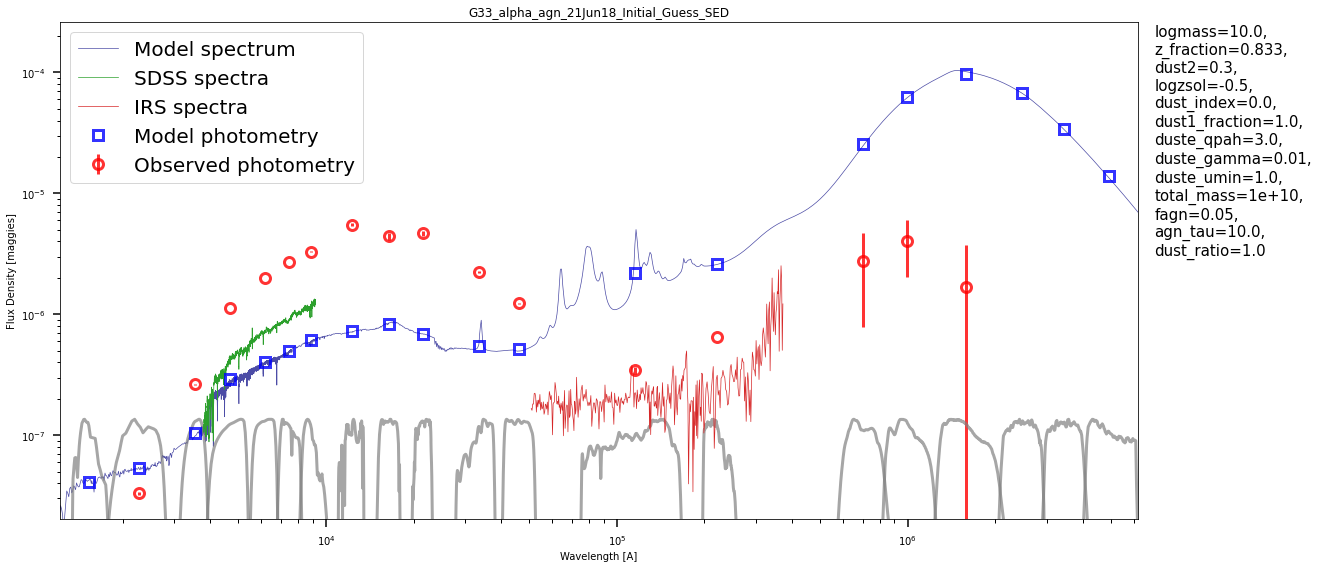

In [206]:
### View Model ###
### prediction for the data from any set of model params

### Generate the model SED at the initial value of theta ###
theta = model.theta.copy()
initial_spec, initial_phot, initial_mfrac = model.sed(theta, obs=obs, sps=sps)
title_text = ','.join(["\n{}={:.3}".format(p, model.params[p][0]) 
                       for p in model.free_params])

a = 1.0 + model.params.get('zred', 0.0) # cosmological redshifting
wphot = obs["phot_wave"]    # photometric effective wavelengths
if obs["wavelength"] is None:
    # spectroscopic wavelengths
    # *restframe* spectral wavelengths, since obs["wavelength"] is None
    wspec = sps.wavelengths
    wspec *= a              # redshift them
else:
    wspec = obs["wavelength"]

xmin, xmax = np.min(wphot)*0.8, np.max(wphot)/0.8
temp = np.interp(np.linspace(xmin,xmax,10000), wspec, initial_spec)
ymin, ymax = temp.min()*0.8, temp.max()/0.4
figure(figsize=(16,8))

# plot model + data
loglog(wspec, initial_spec, label='Model spectrum', 
       lw=0.7, color='navy', alpha=0.7)
errorbar(wphot, initial_phot, label='Model photometry', 
         marker='s',markersize=10, alpha=0.8, ls='', lw=3,
         markerfacecolor='none', markeredgecolor='blue', 
         markeredgewidth=3)
errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'], 
         label='Observed photometry',
         marker='o', markersize=10, alpha=0.8, ls='', lw=3,
         ecolor='red', markerfacecolor='none', markeredgecolor='red', 
         markeredgewidth=3)


figtext(1.005, .55, title_text, ha="left", fontsize=15)
title('G{0}_{1}_{2}_Initial_Guess_SED'.format(galaxy_num, Template_Type, ts))

# plot Filters
for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    t = t / t.max()
    t = 10**(0.2*(np.log10(ymax/ymin)))*t * ymin
    loglog(w, t, lw=3, color='gray', alpha=0.7)

# Plot optical and IRS data if available
plot(optical_spectrum_lam, optical_spectrum_flux, label='SDSS spectra')
if IRS_indicator == 1:
    plot(IRS_wavelength, IRS_flux, label='IRS spectra')

xlabel('Wavelength [A]')
ylabel('Flux Density [maggies]')
xlim([xmin, xmax])
ylim([ymin, ymax])
legend(loc='best', fontsize=20)
tight_layout()

savefig(Galaxy_Path + 'G{0}_{1}_{2}_Initial_Guess_SED_2'.format(galaxy_num, Template_Type, ts))

In [207]:
### Likelyhood Function ###
"""
For nested sampling lnprobfn(theta, nested=True) will return the likelihood (since the prior probability is accounted for by drawing proposals from the priors), while for other types of MCMC sampling lnprobfn(theta, nested=False) returns the posterior probability.
"""

### Running Prospector ###
# Fit the model using chi squared minimization
# Ensemble MCMC sampler around best location from the minimization 
# Dynamic nested sampling with dynesty

# Here we will run all our building functions
obs = build_obs(**run_params)
sps = build_sps(**run_params)
model = build_model(**run_params)

# For fsps based sources it is useful to 
# know which stellar isochrone and spectral library
# print(sps.ssp.libraries)
# help(fit_model)

In [208]:
### Minimization ###
# Uses Levenberg-Marquardt, needed parameters in run_params
# requires a likelihood function that returns a vector of chi values
# imported lnprobfn function takes care of chi values to likelyhood

# --- start minimization ---- # 
run_params["emcee"] = False
run_params["optimize"] = True

if is_free_params < mask_len_array or is_free_params != mask_len_array:
    print('lm Minimization can be done', '\nlength of free parameters =', is_free_params, '\nlength of data points = ', mask_len_array)
    output = fit_model(obs, model, sps, lnprobfn=prospect.fitting.lnprobfn, **run_params)
    print("Done optmization in {}s".format(output["optimization"][1]))
else:
    print('lm Minimization cannot be perfomed because number of data points is <= number of free parameters', '\nlength of free parameters =', is_free_params, '\nlength of data points = ', mask_len_array)

lm Minimization can be done 
length of free parameters = 13 
length of data points =  16
minimizer: Exception while trying to minimize the function:
  params: [ 1.00000000e+01  8.33333333e-01  8.00000000e-01  7.50000000e-01
  6.66666667e-01  5.00000000e-01  3.00000000e-01 -5.00000000e-01
  0.00000000e+00  1.00000000e+00  3.00000000e+00  1.00000000e-02
  1.00000000e+00  1.00000000e+10  5.00000000e-02  1.00000000e+01
  1.00000000e+00]
  args: ()
  exception:
Traceback (most recent call last):
  File "/mnt/c/Users/emma_d/ASTR_Research/lib/python3.8/site-packages/repo/prospector/prospect/fitting/minimizer.py", line 22, in __call__
    return self.f(self.func, x, args=self.args,
  File "/home/emma/.local/lib/python3.8/site-packages/scipy/optimize/_lsq/least_squares.py", line 830, in least_squares
    raise ValueError("Method 'lm' doesn't work when the number of "
ValueError: Method 'lm' doesn't work when the number of residuals is less than the number of variables.


ValueError: Method 'lm' doesn't work when the number of residuals is less than the number of variables.

model.theta [ 1.00000000e+01  8.33333333e-01  8.00000000e-01  7.50000000e-01
  6.66666667e-01  5.00000000e-01  3.00000000e-01 -5.00000000e-01
  0.00000000e+00  1.00000000e+00  3.00000000e+00  1.00000000e-02
  1.00000000e+00  1.00000000e+10  5.00000000e-02  1.00000000e+01
  1.00000000e+00]
ind_best =  0
theta_best =  [ 1.00000000e+01  8.33333333e-01  8.00000000e-01  7.50000000e-01
  6.66666667e-01  5.00000000e-01  3.00000000e-01 -5.00000000e-01
  0.00000000e+00  1.00000000e+00  3.00000000e+00  1.00000000e-02
  1.00000000e+00  1.00000000e+10  5.00000000e-02  1.00000000e+01
  1.00000000e+00]


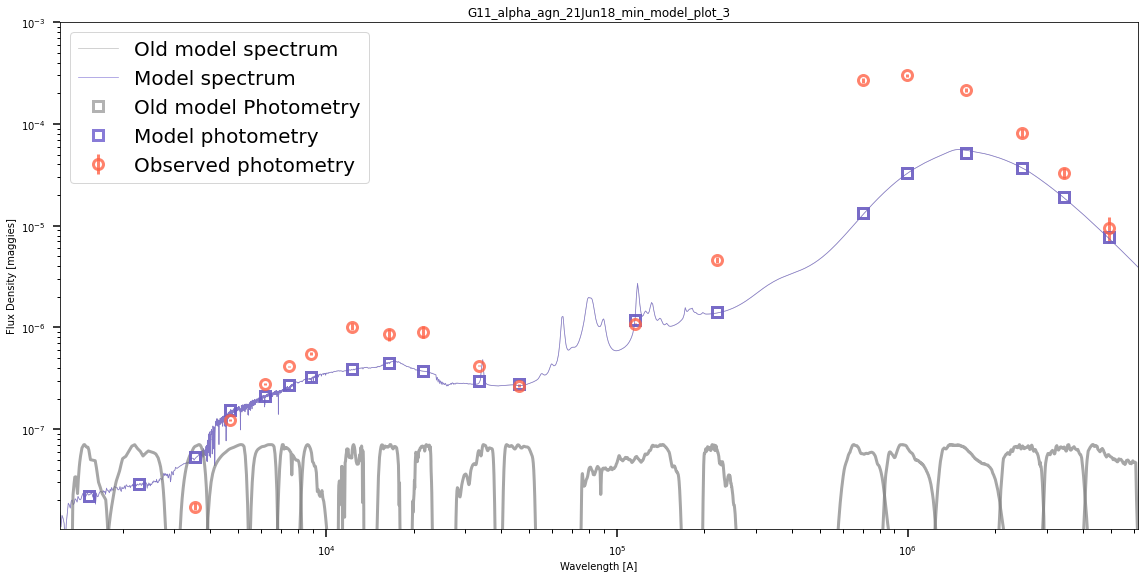

In [76]:

if is_free_params < mask_len_array or is_free_params != mask_len_array:
    print("model.theta", model.theta)
    (results, topt) = output["optimization"]
    # Find which of the minimizations gave the best result, 
    # and use the parameter vector for that minimization
    ind_best = np.argmin([r.cost for r in results])
    print("ind_best = ", ind_best)
    theta_best = results[ind_best].x.copy()
    print("theta_best = ", theta_best)


    # generate model
    prediction = model.mean_model(theta_best, obs=obs, sps=sps)
    pspec, pphot, pfrac = prediction

    figure(figsize=(16,8))

    # wspec * (1 + model.params['zred'])

    # plot Data, best fit model, and old models
    loglog(wspec, initial_spec, label='Old model spectrum',
        lw=0.7, color='gray', alpha=0.5)
    errorbar(wphot, initial_phot, label='Old model Photometry', 
            marker='s', markersize=10, alpha=0.6, ls='', lw=3, 
            markerfacecolor='none', markeredgecolor='gray', 
            markeredgewidth=3)
    loglog(wspec, pspec, label='Model spectrum', 
        lw=0.7, color='slateblue', alpha=0.7) 
    errorbar(wphot, pphot, label='Model photometry', 
            marker='s', markersize=10, alpha=0.8, ls='', lw=3,
            markerfacecolor='none', markeredgecolor='slateblue', 
            markeredgewidth=3)
    errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'],
            label='Observed photometry', 
            marker='o', markersize=10, alpha=0.8, ls='', lw=3, 
            ecolor='tomato', markerfacecolor='none', markeredgecolor='tomato', 
            markeredgewidth=3)

    # plot filter transmission curves
    for f in obs['filters']:
        w, t = f.wavelength.copy(), f.transmission.copy()
        t = t / t.max()
        t = 10**(0.2*(np.log10(ymax/ymin)))*t * ymin
        loglog(w, t, lw=3, color='gray', alpha=0.7)

    xlabel('Wavelength [A]')
    ylabel('Flux Density [maggies]')
    xlim([xmin, xmax])
    ymax = 10**-3
    ylim([ymin, ymax])
    legend(loc='best', fontsize=20)
    tight_layout()

    plt.plot(optical_spectrum_lam, f_nu_to_f_lambda_maggie(optical_spectrum_lam, optical_spectrum_flux), color='k', linewidth=.3)

    if IRS_indicator == 1:
        plt.plot(IRS_wavelength, IRS_flux)
    title('G{0}_{1}_{2}_min_model_plot_3'.format(galaxy_num, Template_Type, ts))
    savefig(Galaxy_Path + 'G{0}_{1}_{2}_min_model_plot_3'.format(galaxy_num, Template_Type, ts))
else:
    print('The prediction cannot be done because minimization was not performed')

In [77]:
run_params["optimize"] = False
run_params["emcee"] = True

In [78]:
output = fit_model(obs, model, sps, lnprobfn=prospect.fitting.lnprobfn, **run_params)
print('done emcee in {0}s'.format(output["sampling"][1]))

/mnt/c/Users/emma_d/ASTR_Research/lib/python3.8/site-packages/repo/prospector/prospect/models/priors.py:104: RuntimeWarning: divide by zero encountered in log
  lnp = np.log(p)
done emcee in 1550.3107659816742s


In [79]:
ts = time.strftime("%y%b%d", time.localtime())
hfile = Galaxy_Path + 'G{0}_{1}_{2}_mcmc.h5'.format(galaxy_num, Template_Type, ts)
obs, model, sps = build_obs(**run_params),  build_model(**run_params), build_sps(**run_params) #, build_all(**run_params)

In [80]:
### Use to save results to disk ###
writer.write_hdf5(hfile, run_params, model, obs, 
                  output["sampling"][0], output["optimization"][0],
                  tsample=output["sampling"][1],
                  toptimize=output["optimization"][1],
                  sps=sps)
                  # Just added in SPS for obtaining result['bestfit']

print('Finished')

/mnt/c/Users/emma_d/ASTR_Research/lib/python3.8/site-packages/repo/prospector/prospect/io/write_results.py:60: RuntimeWarning: Could not store paramfile text
  warnings.warn("Could not store paramfile text", RuntimeWarning)
/mnt/c/Users/emma_d/ASTR_Research/lib/python3.8/site-packages/repo/prospector/prospect/io/write_results.py:290: RuntimeWarning: Could not JSON serialize model_params, pickled instead
  warnings.warn("Could not JSON serialize {}, pickled instead".format(k),
Finished


In [81]:
import prospect.io.read_results as reader
results_type = "emcee" 
# grab results (dictionary), the obs dictionary, and our corresponding models
# When using parameter files set `dangerous=True`

# change to file that was just generated
result, obs, __ = reader.results_from(Galaxy_Path + 'G{0}_{1}_{2}_mcmc.h5'.format(galaxy_num, Template_Type, ts), dangerous=False)

In [82]:
result

{'model_params': [{'N': 1,
   'isfree': True,
   'init': 10.0,
   'units': 'Msun',
   'prior': b'\x80\x02cprospect.models.priors\nTopHat\nq\x00)\x81q\x01}q\x02(X\x05\x00\x00\x00aliasq\x03}q\x04(X\x04\x00\x00\x00miniq\x05h\x05X\x04\x00\x00\x00maxiq\x06h\x06uX\x06\x00\x00\x00paramsq\x07}q\x08(h\x05G@\x14\x00\x00\x00\x00\x00\x00h\x06G@*\x00\x00\x00\x00\x00\x00uX\x04\x00\x00\x00nameq\tX\x00\x00\x00\x00q\nub.',
   'name': 'logmass'},
  {'N': 5,
   'isfree': True,
   'init': array([0.83333333, 0.8       , 0.75      , 0.66666667, 0.5       ]),
   'units': '',
   'init_disp': 0.02,
   'prior': b'\x80\x02cprospect.models.priors\nBeta\nq\x00)\x81q\x01}q\x02(X\x05\x00\x00\x00aliasq\x03}q\x04(X\x04\x00\x00\x00miniq\x05h\x05X\x04\x00\x00\x00maxiq\x06h\x06X\x05\x00\x00\x00alphaq\x07h\x07X\x04\x00\x00\x00betaq\x08h\x08uX\x06\x00\x00\x00paramsq\t}q\n(h\x05G\x00\x00\x00\x00\x00\x00\x00\x00h\x06G?\xf0\x00\x00\x00\x00\x00\x00h\x07cnumpy.core.multiarray\n_reconstruct\nq\x0bcnumpy\nndarray\nq\x0cK\x00\x85q

In [219]:
def get_best_v2(res, **kwargs):
    """Get the maximum a posteriori parameters.
    """
    imax = np.argmax(res['lnprobability'])
    # there must be a more elegant way to deal with differnt shapes
    try:
        i, j = np.unravel_index(imax, res['lnprobability'].shape)
        theta_best = res['chain'][i, j, :].copy()
    except(ValueError):
        theta_best = res['chain'][imax, :].copy()
        
    return  theta_best

In [222]:
## Added from github issue ##

from prospect.utils.plotting import get_best
theta_map = get_best_v2(result)
theta_labels = result['theta_labels']

print(theta_map)
print(result['theta_labels'])

[ 1.03264415e+01  9.32106042e-01  4.06340344e-01  5.63888246e-01
  5.25993096e-01  4.64941096e-01  1.51430250e+00 -1.38847249e+00
 -3.80972029e-01  1.06256095e+00  8.54802519e-02  1.11704576e-03
  1.47212736e+01  1.00000000e+10  7.12514036e-03  6.23969517e+01
  1.40045998e+00]
['logmass', 'z_fraction_1', 'z_fraction_2', 'z_fraction_3', 'z_fraction_4', 'z_fraction_5', 'dust2', 'logzsol', 'dust_index', 'dust1_fraction', 'duste_qpah', 'duste_gamma', 'duste_umin', 'total_mass', 'fagn', 'agn_tau', 'dust_ratio']


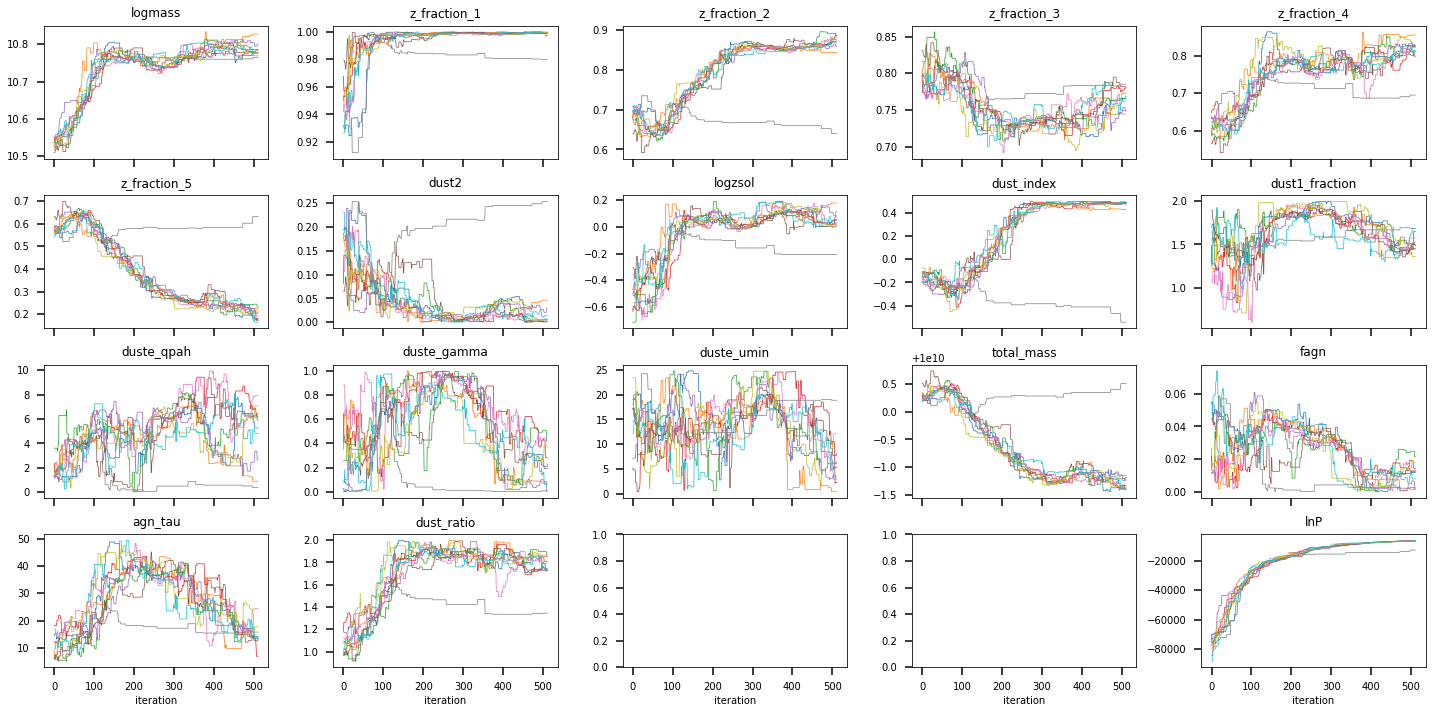

In [264]:
### Plotting Parameter Traces ###
chosen = np.random.choice(result["run_params"]["nwalkers"], size=10, replace=False)
tracefig = reader.traceplot(result, figsize=(20,10), chains=chosen)

savefig(Galaxy_Path + 'G{0}_{1}_{2}_param_trace_4'.format(galaxy_num, Template_Type, ts))

Optimization value: [ 1.00000000e+01  8.33333333e-01  8.00000000e-01  7.50000000e-01
  6.66666667e-01  5.00000000e-01  3.00000000e-01 -5.00000000e-01
  0.00000000e+00  1.00000000e+00  3.00000000e+00  1.00000000e-02
  1.00000000e+00  1.00000000e+10  5.00000000e-02  1.00000000e+01
  1.00000000e+00]
MAP value: [ 1.03264415e+01  9.32106042e-01  4.06340344e-01  5.63888246e-01
  5.25993096e-01  4.64941096e-01  1.51430250e+00 -1.38847249e+00
 -3.80972029e-01  1.06256095e+00  8.54802519e-02  1.11704576e-03
  1.47212736e+01  1.00000000e+10  7.12514036e-03  6.23969517e+01
  1.40045998e+00]


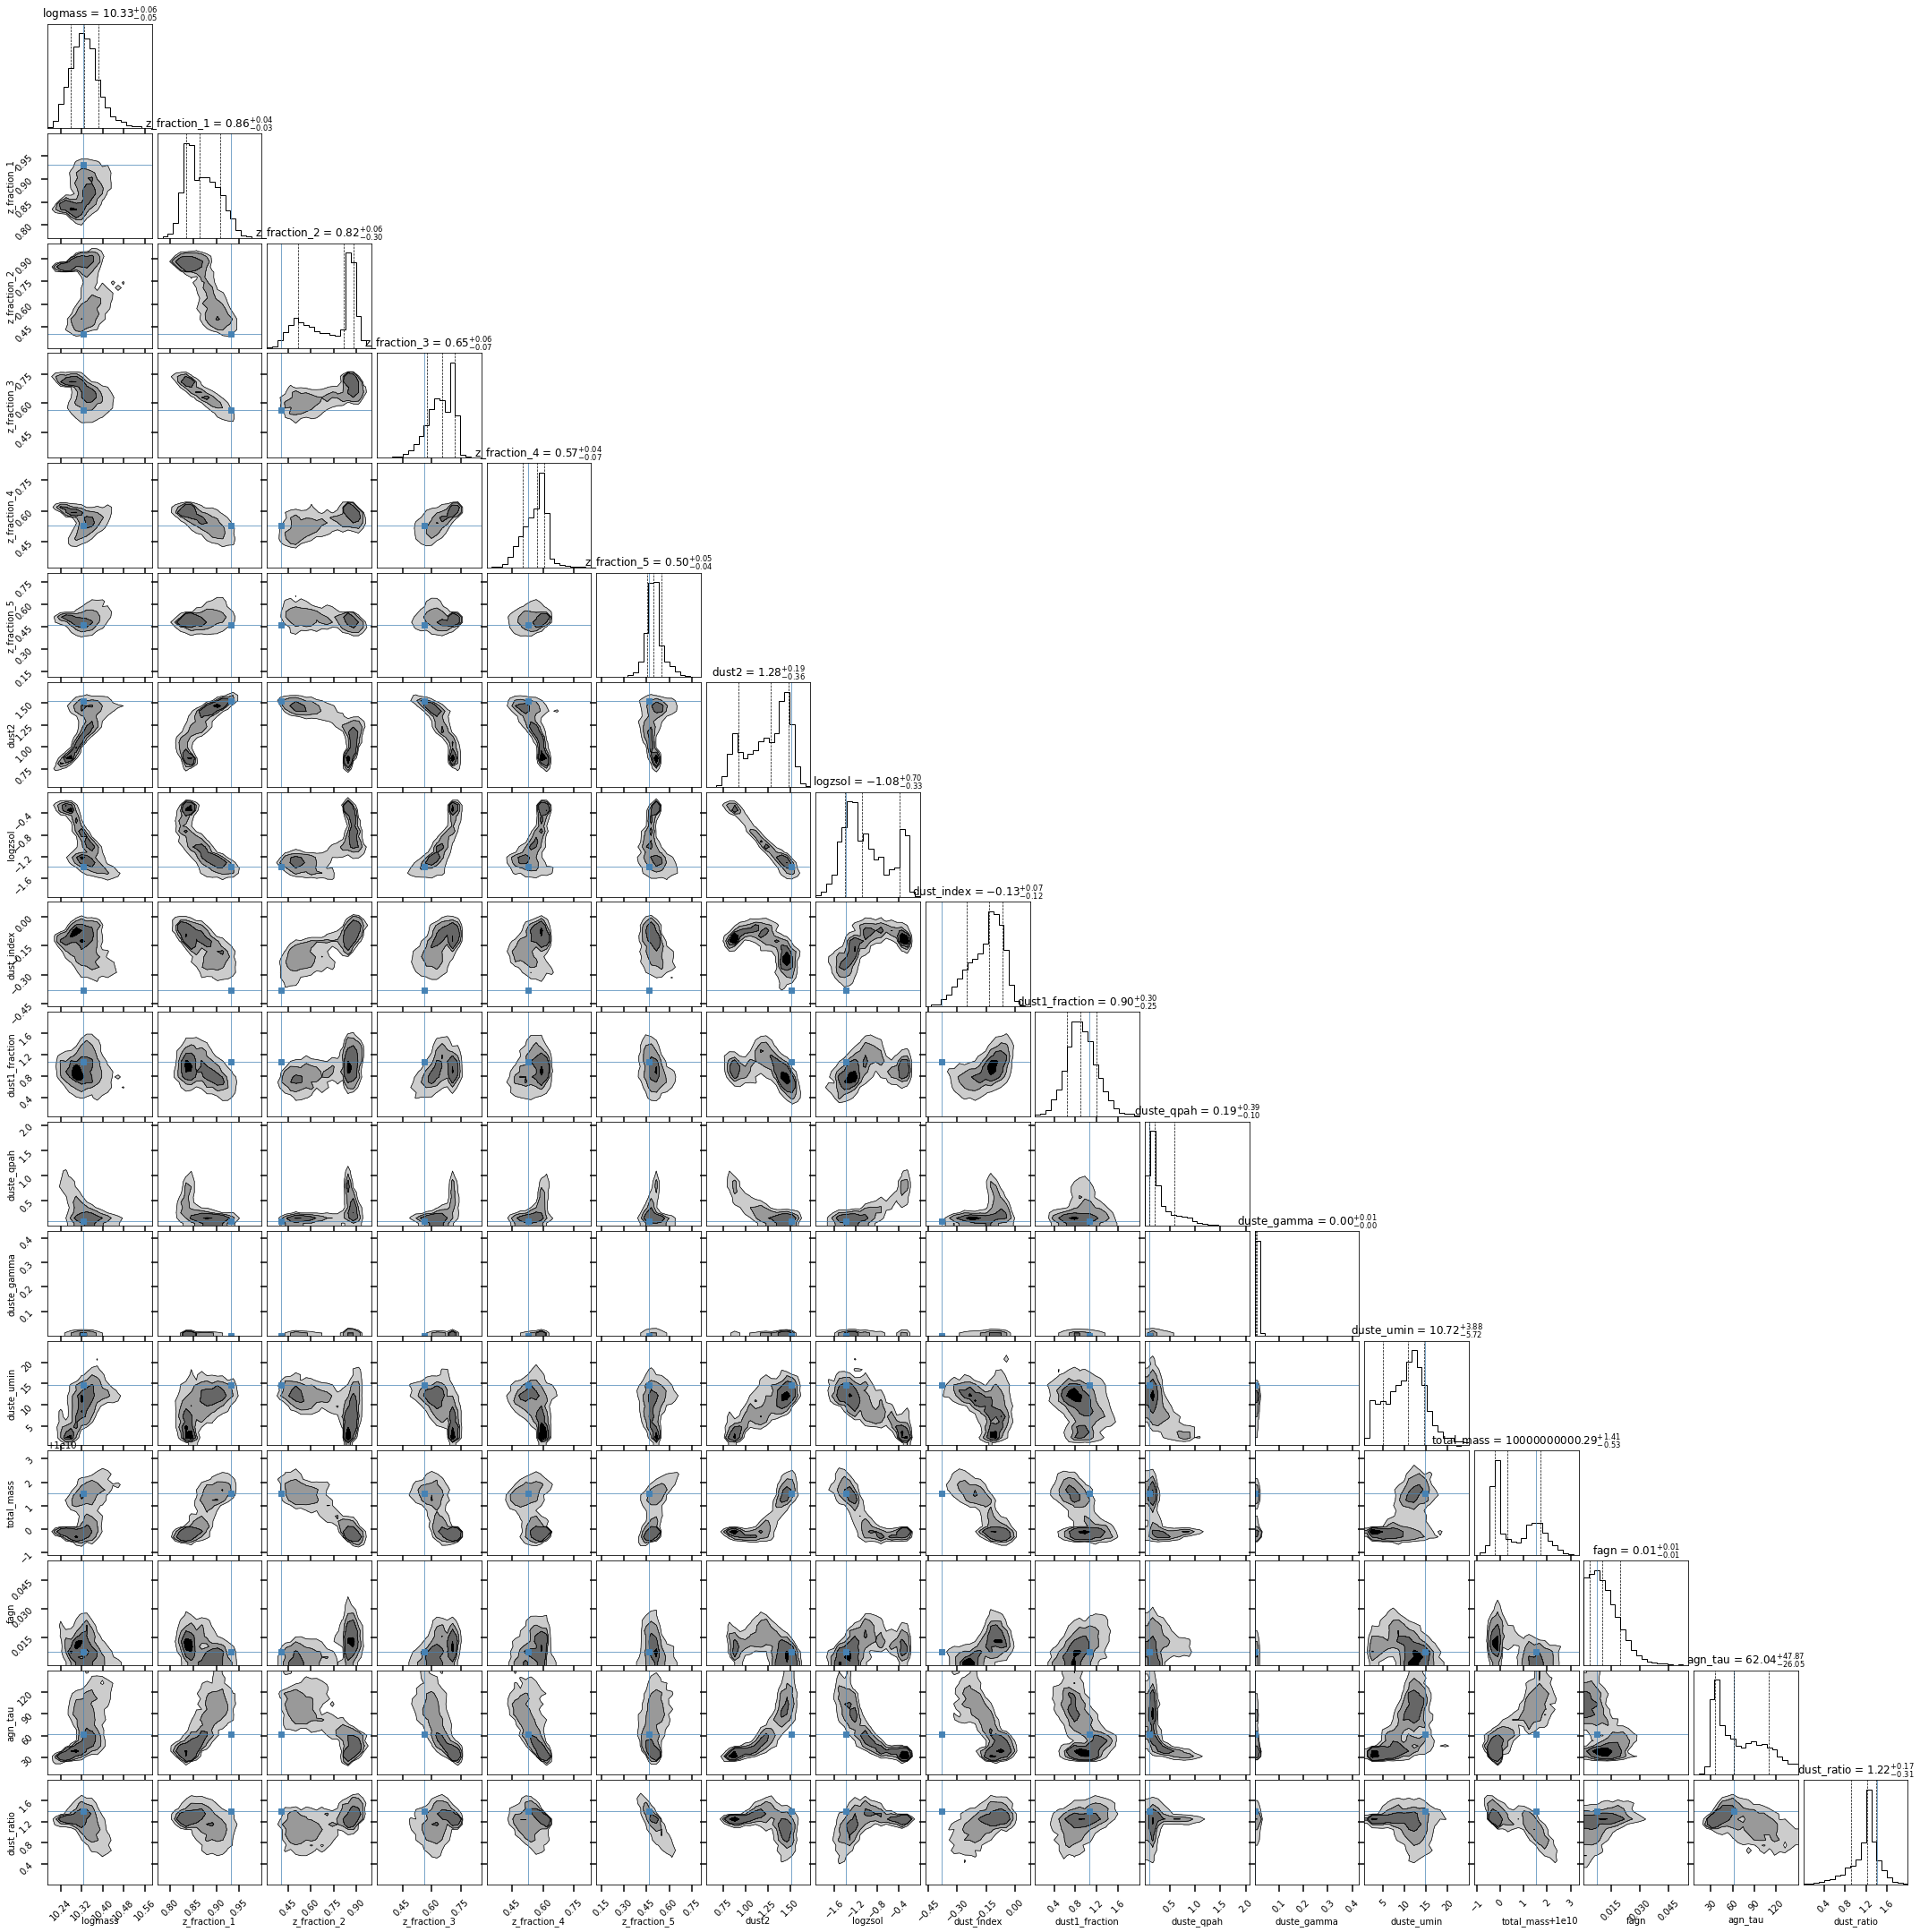

In [230]:
### Corner Plot ###
# maximum a posterior (of the locations visited by the MCMC sampler)
imax = np.argmax(result['lnprobability'])
i, j = np.unravel_index(imax, result['lnprobability'].shape)
theta_max = result['chain'][i, j, :].copy()
thin = 5

if is_free_params < mask_len_array or is_free_params != mask_len_array:
    print('Optimization value: {}'.format(theta_best))
print('MAP value: {}'.format(theta_max))


if is_free_params < mask_len_array or is_free_params != mask_len_array:
    cornerfig = reader.subcorner(result, start=0, thin=thin, truths= result['bestfit']['parameter'],  
                             fig=subplots(17,17,figsize=(30,30))[0])       # MUST modify subplot, 
else:
    cornerfig = reader.subcorner(result, start=0, thin=thin,   
                             fig=subplots(17,17,figsize=(30,30))[0])       # MUST modify subplot, 

savefig(Galaxy_Path + 'G{0}_{1}_{2}_corner_plot_5'.format(galaxy_num, Template_Type, ts))

In [231]:
for i in range(0,len(result['theta_labels'])):
    print(result['theta_labels'][i], ':', theta_max[i], theta_best[i], theta_map[i], result['bestfit']['parameter'][i])

logmass : 10.326441513040168 10.0 10.326441513040168 10.326441513040168
z_fraction_1 : 0.9321060424661195 0.8333333333333334 0.9321060424661195 0.9321060424661195
z_fraction_2 : 0.40634034434901023 0.8 0.40634034434901023 0.40634034434901023
z_fraction_3 : 0.5638882464384933 0.75 0.5638882464384933 0.5638882464384933
z_fraction_4 : 0.5259930960052248 0.6666666666666666 0.5259930960052248 0.5259930960052248
z_fraction_5 : 0.4649410955182434 0.5 0.4649410955182434 0.4649410955182434
dust2 : 1.5143025019690775 0.3 1.5143025019690775 1.5143025019690775
logzsol : -1.3884724894724303 -0.5 -1.3884724894724303 -1.3884724894724303
dust_index : -0.38097202916067946 0.0 -0.38097202916067946 -0.38097202916067946
dust1_fraction : 1.062560952106277 1.0 1.062560952106277 1.062560952106277
duste_qpah : 0.08548025188086184 3.0 0.08548025188086184 0.08548025188086184
duste_gamma : 0.0011170457631716445 0.01 0.0011170457631716445 0.0011170457631716445
duste_umin : 14.721273613021005 1.0 14.72127361302100

In [267]:
# https://github.com/nolaaa/SED_fitting_Prospecotr/blob/master/7_run_prospector_for_all_arcs.ipynb

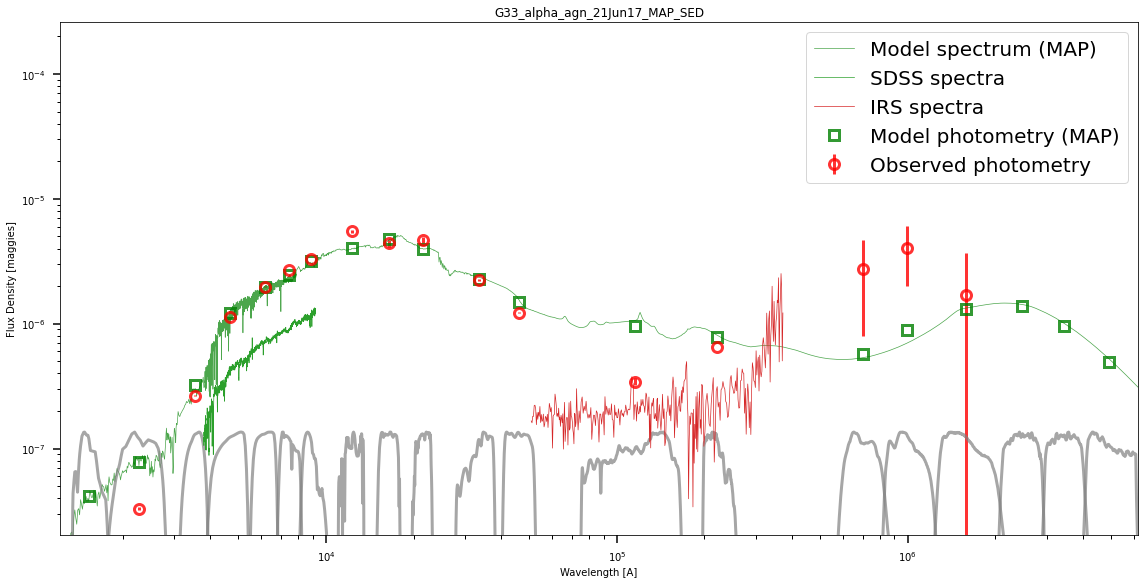

In [268]:
# https://github.com/bd-j/prospector/issues/186

mspec_map, mphot_map, _ = model.mean_model(theta_max, obs, sps=sps)

# Make plot of data and model
figure(figsize=(16,8))

loglog(wspec * (1 + model.params['zred']), mspec_map, label='Model spectrum (MAP)',
       lw=0.7, color='green', alpha=0.7)
errorbar(wphot, mphot_map, label='Model photometry (MAP)',
         marker='s', markersize=10, alpha=0.8, ls='', lw=3, 
         markerfacecolor='none', markeredgecolor='green', 
         markeredgewidth=3)
errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'], 
         label='Observed photometry', ecolor='red', 
         marker='o', markersize=10, ls='', lw=3, alpha=0.8, 
         markerfacecolor='none', markeredgecolor='red', 
         markeredgewidth=3)

# plot transmission curves
for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    t = t / t.max()
    t = 10**(0.2*(np.log10(ymax/ymin)))*t * ymin
    loglog(w, t, lw=3, color='gray', alpha=0.7)

# Plot optical and IRS data if available
plot(optical_spectrum_lam, optical_spectrum_flux, label='SDSS spectra')
if IRS_indicator == 1:
    plot(IRS_wavelength, IRS_flux, label='IRS spectra')

xlabel('Wavelength [A]')
ylabel('Flux Density [maggies]')
xlim([xmin, xmax])
ylim([ymin, ymax])
legend(loc='best', fontsize=20)
tight_layout()
title('G{0}_{1}_{2}_MAP_SED'.format(galaxy_num, Template_Type, ts))

savefig(Galaxy_Path + 'G{0}_{1}_{2}_MAP_SED_6'.format(galaxy_num, Template_Type, ts))

In [269]:
end_time = time.time()
print("this program takes:", end_time - start_time, "seconds to run")
print("this program takes:", (end_time - start_time)/60, "minutes to run")

this program takes: 1586.036304950714 seconds to run
this program takes: 26.433938415845237 minutes to run


In [228]:
result['bestfit'] #https://github.com/bd-j/prospector/issues/215

{'parameter': array([ 1.03264415e+01,  9.32106042e-01,  4.06340344e-01,  5.63888246e-01,
         5.25993096e-01,  4.64941096e-01,  1.51430250e+00, -1.38847249e+00,
        -3.80972029e-01,  1.06256095e+00,  8.54802519e-02,  1.11704576e-03,
         1.47212736e+01,  1.00000000e+10,  7.12514036e-03,  6.23969517e+01,
         1.40045998e+00]),
 'photometry': array([4.28431387e-10, 2.63547034e-09, 2.44366492e-08, 1.28892313e-07,
        2.69381174e-07, 4.10339597e-07, 5.52048528e-07, 4.32363116e-07,
        2.72586938e-07, 1.11173002e-06, 4.65608923e-06, 2.28777685e-04,
        2.79118286e-04, 1.98952798e-04, 7.94736236e-05, 3.02894953e-05,
        1.02150553e-05, 8.93382772e-07, 7.73994141e-07, 7.40653343e-07]),
 'restframe_wavelengths': array([9.100e+01, 9.400e+01, 9.600e+01, ..., 9.817e+07, 9.908e+07,
        1.000e+08]),
 'spectrum': array([2.55386458e-72, 2.55386458e-72, 2.55386458e-72, ...,
        6.50577086e-08, 6.51436693e-08, 6.51913778e-08]),
 'mfrac': 0.6076675599458187}

In [229]:
result['bestfit']['parameter']

array([ 1.03264415e+01,  9.32106042e-01,  4.06340344e-01,  5.63888246e-01,
        5.25993096e-01,  4.64941096e-01,  1.51430250e+00, -1.38847249e+00,
       -3.80972029e-01,  1.06256095e+00,  8.54802519e-02,  1.11704576e-03,
        1.47212736e+01,  1.00000000e+10,  7.12514036e-03,  6.23969517e+01,
        1.40045998e+00])